In [26]:
%matplotlib inline

import urllib.request
import io
import zipfile

from pathlib import Path
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

import igraph as ig

from itertools import combinations

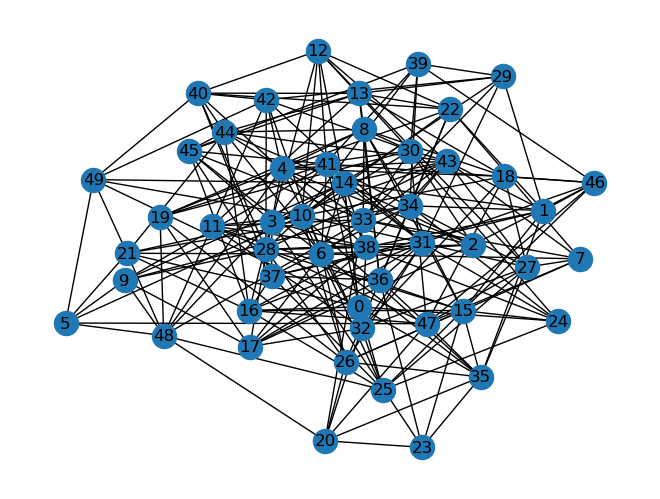

In [57]:
#instance

#inst_="karate"
#G = nx.karate_club_graph()

#inst_="sudoku"
#G = nx.sudoku_graph(50)

#inst_="random_tree"
#G = nx.random_tree(50)

#inst_="random_internet"
#dim=100
#G = nx.random_internet_as_graph(dim)

# erdos_renyi_graph(n, p, seed=None, directed=False)
#G = nx.erdos_renyi_graph(50,0.1)

# barabasi_albert_graph(n, m, seed=None, initial_graph=None)
#G = nx.barabasi_albert_graph()

inst_="erdos"
GI = ig.Graph.Erdos_Renyi(n=50, p=0.2, directed=False, loops=False)
#A = ig.Graph.get_edgelist(GI)
#G = nx.DiGraph(A)
#G = nx.Graph(A)
G = ig.Graph.to_networkx(GI)

#ig.plot(GI)
#nx.draw_networkx_labels(G,pos=nx.spring_layout(G))
nx.draw(G,  with_labels = True)

#print("Node Degree")
#for v in G:
#    print(f"{v:4} {G.degree(v):6}")
#print(G)

In [58]:
nx.is_connected(G)

True

In [59]:
def is_subclique(G, nodelist):
    '''
    For each pair of nodes in nodelist whether there is an edge 
    if any edge is missing, we know that it's not a subclique.
    if all edges are there, it is a subclique
    '''
    for (u,v) in combinations(nodelist,2):  #check each possible pair
        if not G.has_edge(u,v):
            return False #if any edge is missing we're done
    return True  #if we get to here, then every edge was there.  It's True.

In [60]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

dm = np.zeros((N,N), dtype=int)

p = nx.shortest_path(G)

for i in range(0,N):
    for j in range(0,N):
        dm[i][j] = len(p[i][j])-1

#G.edges


In [61]:
#for i in G:
#    Ni = nx.neighbors(G,i)

#    nodelist = []
#    for k in Ni:
#        nodelist.append(k)
    
#    if(is_subclique(G, nodelist)):
#        print("vizinhanca de %d" %i)


In [62]:
# form1
form_="form1"
method_="mip"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)
status = np.zeros((N), dtype=float)

RESULT_PATH   = Path('../result/')

for i in G:

    Ni = nx.neighbors(G,i)

    lista = []
    for k in Ni:
        lista.append(k)
    
    if(is_subclique(G, lista)):
        #print("tukey[%d] = 1" %i)
        lb[i] = 1
        ub[i] = 1
        gap[i] = 0.0
        time[i] = 0.0
        nodes[i] = 0
        status[i] = 1
    else:

        model = gp.Model(f"{method_}_{inst_}_{form_}")

        # configurando parametros
        # model.Params.TimeLimit = 60
        model.Params.MIPGap = 1.e-6
        model.Params.Threads = 1
        # model.Params.Presolve = 0
        # model.Params.Cuts = 0

        if (method_=="mip"):
            x = model.addVars(N, vtype=GRB.BINARY, name="x")
        else:
            x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")

        l = list(tuple())
        for u in range(0, N):
            for w in range(u+1, N):
                l.append((u,w))

        y = model.addVars(l, vtype=GRB.CONTINUOUS, name='y')
#        y = model.addVars(l, vtype=GRB.BINARY, name='y')
   
        obj = 0
        for j in G:
            obj += 1 * x[j]
         
        model.setObjective(obj, GRB.MAXIMIZE)
     
        # Turn off display and heuristics
        gp.setParam('OutputFlag', 0)
        gp.setParam('Heuristics', 0)

        constr = 0
        constr += 1 * x[i]
        model.addConstr(constr == 0)

        for u in range(0,N):
            Nu = nx.neighbors(G,u)
            for w in range(u+1,N):
                #if dm[u,w] <= N:
                for s in range(0,N):
                #for s in Nu:
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            model.addConstr(x[u] + x[w] <= 1 + x[s])

        # maximal independent set constraints
        for u in range(0,N):
            if (u == i):
                Im = nx.maximal_independent_set(G, [i])
                constr = 0
                for k in Im:
                    constr = 1 * x[k]
                model.addConstr(constr <= 1)
            else:
                Im = nx.maximal_independent_set(G, [u])
                constr = 0
                for k in Im:
                    constr = 1 * x[k]
                model.addConstr(constr <= 1 + (len(Im)- 1)*x[u])

        # rlt constraint
        for u in range(0,N):
            for w in range(u+1,N):
                if (u,w) in G.edges:
                    model.addConstr(y[u,w] <= x[u])
                    model.addConstr(y[u,w] <= x[w])
                    model.addConstr(x[u] + x[w] <= 1 + y[u,w])

        #x[i].Start = 0.0
        #relax = model.relax()
        #relax.optimize()

        #model.write(f"{method_}_{inst_}_{form_}.lp")

        model.optimize()

        tmp = 0
        if model.status == GRB.OPTIMAL:
            tmp = 1
    
        if (method_=="mip"):
            lb[i] = N - model.objBound
            ub[i] = N - model.objVal
            gap[i] = model.MIPGap
            time[i] = model.Runtime
            nodes[i] = model.NodeCount
            status[i] = tmp
        else:
            ub[i] = N - model.objVal
            time[i] = model.Runtime
            status[i] = tmp

    if (method_=="mip"):
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status[i],1))+'\n')
        arquivo.close()

tkm = np.max(ub)
tktime = np.sum(time)

In [63]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1

In [64]:
if method_ == "lp":
    for i in G:
        print(
            "node:%d, ub: %2f, time: %2f " % (i, ub[i], time[i])
            )
    
    print("tkm : %.2f" %(tkm))
    print("tkm : %.2f" %(tktime))

if method_ == "mip":
    for i in G:
        print(
            "node:%d, lb: %d, ub: %d, gap: %.2f, time: %.2f, nodes: %d, status: %d " 
            % (i, lb[i], ub[i], gap[i], time[i], nodes[i], status[i])
            )
    
    print("tkm : %.2f" %(tkm))
    print("tkm : %.2f" %(tktime))

node:0, lb: 44, ub: 44, gap: 0.00, time: 0.93, nodes: 250, status: 1 
node:1, lb: 44, ub: 44, gap: 0.00, time: 0.67, nodes: 234, status: 1 
node:2, lb: 44, ub: 44, gap: 0.00, time: 0.60, nodes: 236, status: 1 
node:3, lb: 45, ub: 45, gap: 0.00, time: 0.52, nodes: 284, status: 1 
node:4, lb: 44, ub: 44, gap: 0.00, time: 0.50, nodes: 274, status: 1 
node:5, lb: 44, ub: 44, gap: 0.00, time: 0.83, nodes: 303, status: 1 
node:6, lb: 44, ub: 44, gap: 0.00, time: 0.78, nodes: 295, status: 1 
node:7, lb: 44, ub: 44, gap: 0.00, time: 1.05, nodes: 281, status: 1 
node:8, lb: 44, ub: 44, gap: 0.00, time: 0.63, nodes: 297, status: 1 
node:9, lb: 44, ub: 44, gap: 0.00, time: 0.55, nodes: 276, status: 1 
node:10, lb: 44, ub: 44, gap: 0.00, time: 0.54, nodes: 272, status: 1 
node:11, lb: 44, ub: 44, gap: 0.00, time: 0.50, nodes: 281, status: 1 
node:12, lb: 44, ub: 44, gap: 0.00, time: 0.69, nodes: 290, status: 1 
node:13, lb: 44, ub: 44, gap: 0.00, time: 0.58, nodes: 323, status: 1 
node:14, lb: 44,